In [11]:
import pdb
import sys
import argparse
import itertools

import numpy as np
from scipy.stats import norm

sys.path.insert(0, '../../../network')
from transfer_functions import LIF, ReLU

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.insert(0, '../../../figures')
import plot_utils as pu
import color_scheme as cs

In [12]:
datapath1 = "data/data_a.npy"
datapath2 = "data/data_b_testing.npy"
datapath3 = "data/data_c.npy"

**Panels a, b**: Rate network

In [13]:
def plot_rate_panel(datapath, axes, ylabels, title, neuron_idxs):

    correlations, state_exc, state_inh, phi_params = np.load(open(datapath, "rb"), allow_pickle=True)

    tick_fontsize = 5
    label_fontsize = 5

    exc_phi_params = phi_params["phi_E"]
    inh_phi_params = phi_params["phi_I"]

    # Excitatory transfer function
    if exc_phi_params:
        if exc_phi_params["type"] == "relu":
            phif_E = ReLU(**exc_phi_params).phi
        elif exc_phi_params["type"] == "lif":
            phif_E = LIF(**exc_phi_params).phi
        else:
            raise NotImplementedError

    # Inhibitory transfer function
    if inh_phi_params:
        if inh_phi_params["type"] == "relu":
            phif_I =  ReLU(**inh_phi_params).phi
        elif inh_phi_params["type"] == "lif":
            phif_I = LIF(**inh_phi_params).phi
        else:
            raise NotImplementedError

    # Plot correlations
    cmap = matplotlib.cm.get_cmap("bone")
    colors = [cmap(x) for x in np.linspace(0.1,0.7,correlations.shape[0])[::1]]
    for correlation, c in zip(correlations, colors):
        axes[0].plot(correlation, c=c, linewidth=1)
    axes[0].set_ylim([-0.05,0.6])
    axes[0].set_yticks([0,0.4,0.8])
    axes[0].set_yticklabels([0,0.4,0.8])

    for i, c in zip(neuron_idxs, exc_colors):
        axes[1].plot(phif_E(state_exc[i,:]), c=c, alpha=1.0, linewidth=1.0) #2
    axes[1].set_yticks([0,100])
    axes[1].set_ylim([0,300])
    axes[1].set_yticks([0,300])
    axes[1].set_yticklabels([0,300])

    inset_axes = []
    inset_params = [.75, .70, .2, .25] # left, bottom, width, height

    # Plot excitatory firing rates
    ax1 = axes[1].inset_axes(inset_params) 
    if exc_phi_params["type"] == "lif":
        x = np.linspace(-10,10,100)
        inset_title = "LIF"
    elif exc_phi_params["type"] == "relu": 
        x = np.linspace(-5,10,100)
        inset_title = "Linear"
    else:
        raise Exception("Rate transfer function not found")

    ax1.plot(x, phif_E(x), color='k')
    ax1.set_xlabel("Input", fontsize=4, labelpad=1)
    ax1.set_ylabel("Rate", fontsize=4, labelpad=1)
    ax1.set_title(inset_title, fontsize=4, pad=0)
    inset_axes.append(ax1)

    # Plot excitatory raster
    r = phif_E(state_exc[:,:])
    times = np.asarray([np.argmax(r_[:]) for r_ in r])
    idxs = np.arange(times.size)[np.argsort(times)]
    active_mask = [np.any(r_[:] > 0.01) for r_ in r[idxs]]
    active_idxs = idxs[active_mask]
    axes[2].pcolormesh(r[active_idxs][::100], vmax=150, cmap="Reds", rasterized=True)

    # Plot inhibitory firing rates
    if len(axes) == 4:
        if inh_phi_params:
            for i, c in zip(range(5), inh_colors):
                axes[-1].plot(phif_I(state_inh.T[:,-i-1]), c=c, alpha=1.0, linewidth=1)

            # Inhibitory transfer function inset
            inset_params = [.75, .70, .2, .25] # left, bottom, width, height
            ax2 = axes[3].inset_axes(inset_params)
            if inh_phi_params["type"] == "lif":
                x = np.linspace(-10,10,100)
                inset_title = "LIF"
            elif inh_phi_params["type"] == "relu":
                x = np.linspace(-5,25,100)
                inset_title = "Linear"
            else:
                raise Exception("Rate transfer function not found")
            ax2.plot(x, phif_I(x), color='k')
            ax2.set_xlabel("Input", fontsize=4, labelpad=1)
            ax2.set_ylabel("Rate", fontsize=4, labelpad=1)
            ax2.set_title(inset_title, fontsize=4, pad=0)
            ax2.set_ylim([0,100])
            ax2.set_yticks([0,100])
            ax2.set_yticklabels([0,100])
            ax2.set_xlim([-5,5])
            ax2.set_xticks([0,5])
            inset_axes.append(ax2)
            axes[3].set_yticks([0,300])
            axes[3].set_yticklabels([0,300])
            axes[3].set_ylim([0,300])
        else:
            axes[-1].set_yticks([])
            axes[-1].annotate(
                    "No inhibitory units",
                    xy=(0.2,0.2),
                    xytext=(0.20,0.45),
                    textcoords="axes fraction",
                    fontsize=16,
                    color='gray')
    
    # x-axis
    for ax in axes:
        ax.set_xlim([0,500])
    for ax in axes[:-1]:
        ax.set_xticks([])
        ax.set_xticks([])
    axes[-1].set_xticks([0, 100, 200, 300, 400, 500])
    axes[-1].set_xticklabels([0, 100, 200, 300, 400, 500], fontsize=label_fontsize)
    axes[-1].set_xlabel("Time (ms)", fontsize=label_fontsize)
    
    # y-axis
    axes[2].set_yticks([])
    for n, text in enumerate(ylabels):
        axes[n].set_ylabel(text, fontsize=label_fontsize) 
    axes[0].set_ylabel("Correlation", fontsize=label_fontsize, labelpad=2)
    
    # insets and spines
    for ax in axes:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    for axes_group in [axes]:#, inset_axes]:
        for n, ax in enumerate(axes_group):
            ax.get_xaxis().tick_bottom()
            ax.get_yaxis().tick_left()
            ax.tick_params(axis='both', which='major', labelsize=8, width=1.0, length=3, pad=1)
            [i.set_linewidth(1.0) for i in ax.spines.values()]
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(label_fontsize)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(label_fontsize)
    for n, ax in enumerate(inset_axes):
        ax.tick_params(axis='both', which='major', labelsize=4, width=0.5, length=3.0, pad=1)
        [i.set_linewidth(0.5) for i in ax.spines.values()]

    axes[0].set_title(title, fontsize=6)

**Panel c**: Spiking network

In [14]:
def plot_spiking_panel(datapath, axes, ylabels, title, neuron_idxs):

    [correlations,
     v_exc, rate_exc, spks_exc,
     v_inh, rate_inh, spks_inh,
     exc_thresh] = np.load(open(datapath, "rb"), allow_pickle=True)

    tick_fontsize = 5
    label_fontsize = 5

    # Plot correlations
    cmap = matplotlib.cm.get_cmap("bone")
    colors = [cmap(x) for x in np.linspace(0.1,0.7,correlations.shape[0])[::1]]
    for correlation, c in zip(correlations, colors):
        axes[0].plot(correlation, c=c, linewidth=1)
    axes[0].set_ylim([-0.05,0.8])
    axes[0].set_yticks([0,0.4,0.8])
    axes[0].set_yticklabels([0,0.4,0.8])
    
    # Plot excitatory voltages
    for i, c in zip(neuron_idxs, exc_colors):
        axes[1].plot(
            np.arange(v_exc[i].size),
            v_exc[i]-70,
            c=c,
            alpha=1.0,
            linewidth=0.5)
        axes[1].vlines(
            spks_exc[i].nonzero()[-1],
            ymin=exc_thresh-70,
            ymax=0,
            linewidth=0.5,
            color=c)
    axes[1].set_yticks([-70,0])
    axes[1].set_yticklabels([-70,0])
    
    # Plot excitatory raster (sorted)
    times = np.asarray([np.argmax(r[:]) for r in rate_exc])
    idxs = np.arange(times.size)[np.argsort(times)]
    active_mask = [np.any(r[:] > 0.0) for r in rate_exc[idxs]]
    active_idxs = idxs[active_mask]
    x, y = np.nonzero(spks_exc[active_idxs,:].T[:,::200])
    axes[2].scatter(
        x,
        y,
        s=1,
        c="indianred",
        marker='|',
        rasterized=True)
    
    # Plot inhibitory raster
    x, y = np.nonzero(spks_inh.T[:,::50])
    axes[3].scatter(
        x,
        y,
        s=1,
        c="royalblue",
        marker='|',
        rasterized=True)
    
    # x-axis
    for ax in axes:
        ax.set_xlim([0,500])
    for ax in axes[:-1]:
        ax.set_xticks([])
        ax.set_xticks([])
    axes[-1].set_xticks([0, 100, 200, 300, 400, 500])
    axes[-1].set_xticklabels([0, 100, 200, 300, 400, 500], fontsize=label_fontsize)
    axes[-1].set_xlabel("Time (ms)", fontsize=label_fontsize)
    
    # y-axis
    for ax in axes[-2:]:
        ax.set_yticks([])
    for n, text in enumerate(ylabels):
        axes[n].set_ylabel(text, fontsize=label_fontsize) 
    axes[0].set_ylabel("Correlation", fontsize=label_fontsize, labelpad=2)
    
    # inset and spines
    inset_axes = []
    for ax in axes:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    for axes_group in [axes, inset_axes]:
        for n, ax in enumerate(axes_group):
            ax.get_xaxis().tick_bottom()
            ax.get_yaxis().tick_left()
            ax.tick_params(axis='both', which='major', labelsize=8, width=1.0, length=3, pad=1)
            [i.set_linewidth(1.0) for i in ax.spines.values()]
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(label_fontsize)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(label_fontsize)

    axes[0].set_title(title, fontsize=6)

Plot

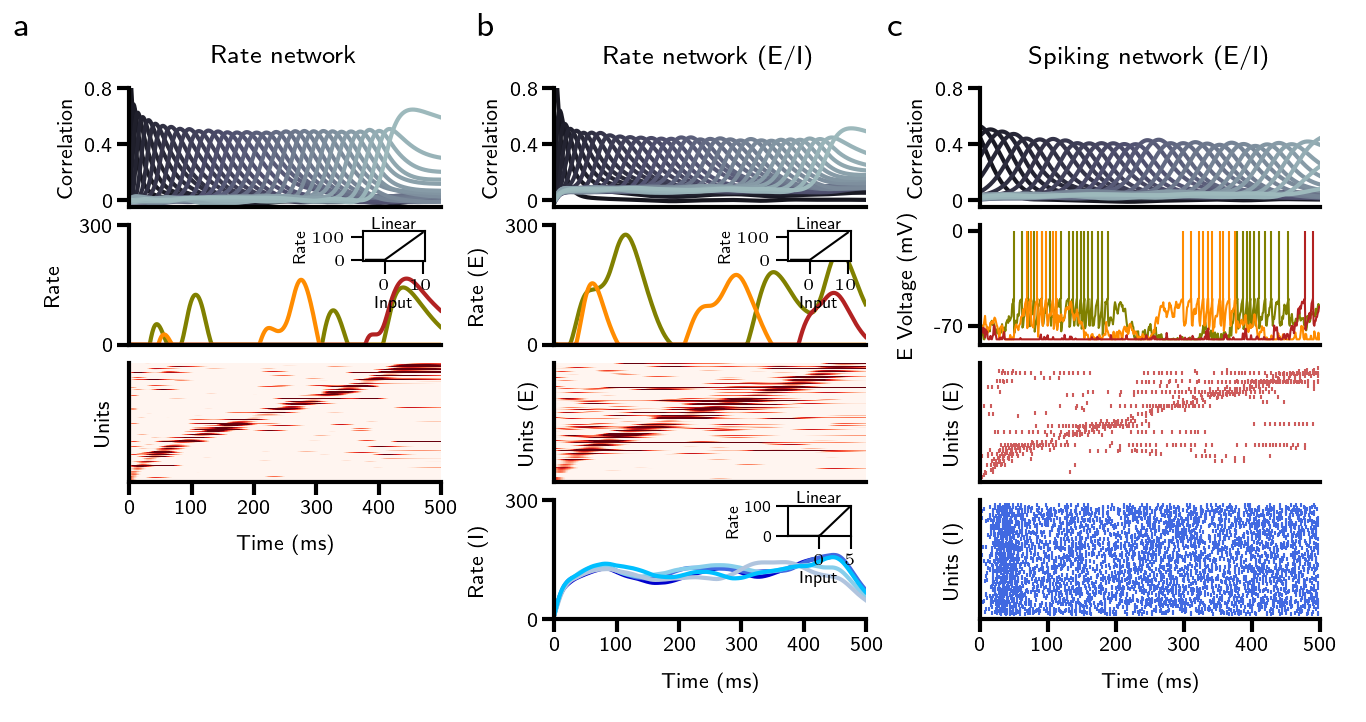

In [15]:
exc_neuron_idxs = [19,23,26]

exc_colors = ['olive', 'darkorange', 'firebrick']
inh_colors = ['mediumblue','royalblue','skyblue','lightsteelblue','deepskyblue']

pu.figure_setup({
  'axes.linewidth': 0.5,
  'lines.linewidth': 0.5,
})
fig_size = pu.get_fig_size(12, 6)
fig = plt.figure(figsize=fig_size, dpi=300)

# Panel a
gs1 = gridspec.GridSpec(4, 1)
gs1.update(left=0.08, right=0.30, top=0.9, bottom=0.15, wspace=0.1, hspace=0.15)
ax1 = plt.subplot(gs1[0, :])
ax2 = plt.subplot(gs1[1, :])
ax3 = plt.subplot(gs1[2, :])
ax1.annotate("a", xy=(0.01,0.95), xycoords='figure fraction', fontsize=8)

# Panel b
gs2 = gridspec.GridSpec(4, 1)
gs2.update(left=0.38, right=0.60, top=0.9, bottom=0.15, wspace=0.1, hspace=0.15)
ax5 = plt.subplot(gs2[0, :])
ax6 = plt.subplot(gs2[1, :])
ax7 = plt.subplot(gs2[2, :])
ax8 = plt.subplot(gs2[3, :])
ax5.annotate("b", xy=(0.35,0.95), xycoords='figure fraction', fontsize=8)

# Panel c
gs3 = gridspec.GridSpec(4, 1)
gs3.update(left=0.68, right=0.92, top=0.9, bottom=0.15, wspace=0.1, hspace=0.15)
ax9 = plt.subplot(gs3[0, :])
ax10 = plt.subplot(gs3[1, :])
ax11 = plt.subplot(gs3[2, :])
ax12 = plt.subplot(gs3[3, :])
ax9.annotate("c", xy=(0.65,0.95), xycoords='figure fraction', fontsize=8)

plot_rate_panel(datapath1,
        [ax1, ax2, ax3], 
        ylabels=["Correlation", "Rate", "Units"],
        title="Rate network",
        neuron_idxs=exc_neuron_idxs)
plot_rate_panel(datapath2,
        [ax5, ax6, ax7, ax8],
        ylabels=["Correlation", "Rate (E)", "Units (E)", "Rate (I)"],
        title="Rate network (E/I)",
        neuron_idxs=exc_neuron_idxs)
plot_spiking_panel(datapath3, 
        [ax9, ax10, ax11, ax12],
        ylabels=["Correlation", "E Voltage (mV)", "Units (E)", "Units (I)"],
        title="Spiking network (E/I)",
        neuron_idxs=exc_neuron_idxs)

plt.savefig("../output/7.pdf", dpi=300)